In [1]:
import pyblp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import copy 
import statsmodels.api as sm

pyblp.options.digits = 2
pyblp.options.verbose = False
pyblp.__version__

'0.12.0'

In [2]:
dataset= pd.read_csv('Yr18_PSet_BLP_data_no_header.txt', delimiter= '\t',
                     header=None, names= ['prices', 'quantity', 'weight', 'power', 'ac', 'firm_ids'])

In [3]:
dataset['market_ids']=1

In [4]:
dataset[['prices', 'quantity', 'weight', 'power', 'ac']].describe()

,prices,quantity,weight,power,ac
count,131.000000,131.000000,131.000000,131.000000,131.000000
mean,18349.091603,66377.312977,2923.465649,133.587786,0.458015
std,12342.785926,74854.734184,564.955578,45.874556,0.500147
min,4435.000000,1037.000000,1620.000000,55.000000,0.000000
25%,10412.500000,14488.500000,2526.500000,100.000000,0.000000
50%,13800.000000,39602.000000,2839.000000,130.000000,0.000000
75%,23400.000000,94776.000000,3329.000000,160.000000,1.000000
max,73800.000000,417179.000000,4283.000000,278.000000,1.000000


In [5]:
#Data Pre-processing: change scale of variables to [0,1]:
dataset['prices']= dataset['prices']/10000
dataset['weight']= dataset['weight']/1000
dataset['power']= dataset['power']/100

In [6]:
M= 100000000 # Market size: 100 million
dataset['shares']= dataset['quantity']/M
dataset_gh= copy.deepcopy(dataset)

### Question 5: Logit and logit with supply side

In [7]:
#  BLP type instruments
demand_instruments = pyblp.build_blp_instruments(pyblp.Formulation('1 + weight + power + ac'), dataset)
for i in range(demand_instruments[0].size):
    dataset[f'demand_instruments{i}']= demand_instruments[:,i]
#     dataset[f'supply_instruments{i}']= demand_instruments[:,i]

# data2= dataset.copy()
# data2['market_ids']=2
# dataset= dataset.append(data2, ignore_index=True)
# dataset['market_ids']

In [53]:
# GH type instruments
cols = [c for c in dataset_gh.columns if c.lower()[:4] != 'dema']
dataset_gh= dataset_gh[cols]
gh_instruments = pyblp.build_differentiation_instruments(pyblp.Formulation('0+ weight + power+ ac'), dataset)
for i in range(gh_instruments[0].size):
    dataset_gh[f'demand_instruments{i}']= gh_instruments[:,i]
blp_instruments = pyblp.build_blp_instruments(pyblp.Formulation(' 1'), dataset)

dataset_gh[f'demand_instruments{i+1}']= blp_instruments[:,0]
dataset_gh[f'demand_instruments{i+2}']= blp_instruments[:,1]

dataset_gh.head()

,prices,quantity,weight,power,ac,firm_ids,market_ids,shares,demand_instruments0,demand_instruments1,demand_instruments2,demand_instruments3,demand_instruments4,demand_instruments5,demand_instruments6,demand_instruments7
0,0.6488,90808,2.020,0.78,0,1,1,0.000908,4.0,4.0,4.0,59.0,79.0,66.0,8.0,122.0
1,0.8748,228211,2.390,1.02,0,1,1,0.002282,5.0,5.0,4.0,82.0,102.0,66.0,8.0,122.0
2,1.1588,284595,2.690,1.15,0,1,1,0.002846,7.0,5.0,4.0,99.0,105.0,66.0,8.0,122.0
3,1.2268,78521,2.500,1.03,0,1,1,0.000785,5.0,5.0,4.0,88.0,102.0,66.0,8.0,122.0
4,1.4898,14257,2.599,1.30,0,1,1,0.000143,5.0,6.0,4.0,93.0,107.0,66.0,8.0,122.0


In [9]:
logit_formulation = pyblp.Formulation('prices+ weight + power + ac ' )
logit_formulation

1 + prices + weight + power + ac

In [10]:
pyblp.options.collinear_atol= 0
pyblp.options.collinear_rtol= 0 # only one market, need to disable this
problem = pyblp.Problem(logit_formulation, dataset)
problem

Dimensions:
 T    N    F    K1    MD 
---  ---  ---  ----  ----
 1   131  20    5     12 

Formulations:
     Column Indices:         0     1       2       3     4 
--------------------------  ---  ------  ------  -----  ---
X1: Linear Characteristics   1   prices  weight  power  ac 

In [11]:
logit_demandonly= problem.solve()
logit_demandonly

Problem Results Summary:
GMM   Objective  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Shares   Condition Number  Condition Number 
----  ---------  -------  ----------------  -----------------
 2    +5.8E-02      0         +1.9E+21          +1.4E+03     

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         2     

Beta Estimates (Robust SEs in Parentheses):
    1         prices      weight      power         ac    
----------  ----------  ----------  ----------  ----------
 -9.5E+00    -1.2E+00    +1.0E+00    +7.0E-01    -1.8E-01 
(+7.7E-01)  (+4.2E-01)  (+3.4E-01)  (+8.4E-01)  (+3.9E-01)

In [12]:
logit_supply_formulation = (pyblp.Formulation('prices+ weight + power + ac ' ),
                            None,
                            pyblp.Formulation('weight + power + ac ' ))
logit_supply_formulation
problem = pyblp.Problem(logit_supply_formulation, dataset)
problem


Dimensions:
 T    N    F    K1    K3    MD    MS 
---  ---  ---  ----  ----  ----  ----
 1   131  20    5     4     12    4  

Formulations:
        Column Indices:           0     1       2       3     4 
-------------------------------  ---  ------  ------  -----  ---
  X1: Linear Characteristics      1   prices  weight  power  ac 
X3: Linear Cost Characteristics   1   weight  power    ac       

In [13]:
logit_supply= problem.solve(
    beta = [None, -1, None, None, None] )
logit_supply

Problem Results Summary:
GMM   Objective  Gradient            Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Hessian   Shares   Condition Number  Condition Number 
----  ---------  --------  --------  -------  ----------------  -----------------
 2    +3.2E-01   +4.8E-09  +2.0E-01     0         +2.1E+19          +1.2E+04     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective 
   Time      Converged   Iterations   Evaluations
-----------  ---------  ------------  -----------
 00:00:01       Yes          2             8     

Beta Estimates (Robust SEs in Parentheses):
    1         prices      weight      power         ac    
----------  ----------  ----------  ----------  ----------
 -1.0E+01    -1.1E+00    +1.4E+00    +2.3E-01    -2.6E-01 
(+8.0E-01)  (+3.7E-01)  (+3.2E-01)  (+7.1E-01)  (+3.5E-01)

Gamma Estimates (Robust SEs in Parentheses):
    1         weight      power         ac    
----------  ----------  ----------  ----------
 -

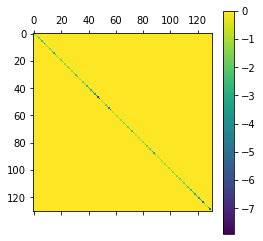

In [14]:
plt.colorbar(plt.matshow(logit_supply.compute_elasticities()));

### Question 6: Other alternatives:

* Nested logit model: it will help a little, but largely depends on the
selection of nests.

* pure characteristics model: it will help because it tries to meliorate
the effect of iid error term, but it is hard to estimate in this setting.

* multinomial probit: it also suffers from iid error problem (unless we
allow for correlations which is also hard to implement in this setting.)


### Question 7: BLP with observed heterogeneity

BLP: $u_{ij}=x_{j}\beta -\alpha _{i}p_{j}+\xi _{j}+\varepsilon _{ij}$
where $\alpha _{i}=\frac{1}{y_{i}}.$ Then $\delta _{j}=x_{j}\beta +\xi _{j}.$

The estimation will involve a Berry's inversion in the outer loop.What
we do here is to (given the distribution parameters of lognormal) calculate:

$$
s_{j}=\int \frac{e^{\delta _{j}-\frac{p_{j}}{y_{i}}}f\left( y_{i}\right)
dy_{i}}{1+\sum_{l}e^{\delta _{l}-\frac{p_{l}}{y_{i}}}f\left( y_{i}\right)
dy_{i}}
$$

repeat using contraction mapping: (until convergence, we set $\left\vert 
\hat{\delta}_{j+1}-\hat{\delta}_{j}\right\vert \leq 10^{-6}$, dropping 1
digit with 100 loops, start with logit value).%
* step 1:
$$
\hat{s}_{j}=\int_{y_{i}}\frac{\exp (\hat{\delta}_{j}-%
\frac{p_{j}}{y_{i}})dF\left( y_{i}\right) }{1+\sum_{k}\exp (\hat{\delta}_{j}-%
\frac{p_{k}}{y_{i}})dF\left( y_{i}\right) }=\frac{1}{N}\sum_{r=1}^{N}\frac{%
\exp (\hat{\delta}_{j}-\frac{p_{j}}{y_{r}})}{1+\sum_{k}\exp (\hat{\delta}%
_{k}-\frac{p_{k}}{y_{r}})}
$$
* step 2:
$$
\exp \left( \hat{\delta}_{j+1}\right) =\exp \left( 
\hat{\delta}_{j}\right) \frac{s_{obs}}{\hat{s}_{j}}
$$

where $\left\{ y_{r}\right\} _{r=1}^{N}$ is directly drawn from the
lognormal distribution given the distribution parameter $(\mu ,\sigma ).$

And then use GMM model to estimate $\beta $ and $\mu ,\sigma .$

Given $\alpha _{i}=\alpha _{1}+\frac{\alpha _{2}}{y_{i}}.$ $\delta
_{j}=x_{j}\beta -\alpha _{1}p_{j}+\xi _{j}.$Now the inversion becomes:%
$$
\ln (s_{j})-\ln \left( s_{0}\right) =\int_{y_{i}}(\delta _{j}-(\alpha _{1}+%
\frac{\alpha _{2}}{y_{i}}p_{j})dF\left( y_{i}\right) 
$$

Now we have another parameter $\alpha _{1}$ and $\alpha _{2}$ here to
estimate as a nonlinear parameter. It is hard to estimate without
instruments because the distribution of lognormal $\mu $ and $\alpha _{2}$
are compounding effects. It is not possible to seperately identify all of
them three. Given our limited sample data, it is not likely that $\alpha _{1}
$ can be identified too.

In [57]:
# Add agent data from lognormal draw (35000, 45000)
integration = pyblp.Integration('halton', size=100, specification_options={'seed': 0})
integration
agent_data_array= pyblp.build_integration(integration, 1)
agent_data_array.nodes
agent_data= pd.DataFrame.from_records(agent_data_array.weights, index=range(100), columns=['weights'])
m= 35000
v= 45000

agent_data['income']= np.exp(np.sqrt(np.log(v**2/m**2+1))*agent_data_array.nodes
                    + np.log(m**2/np.sqrt(v**2+ m**2)) )/10**3
agent_data['market_ids']=1
agent_data['nodes']= agent_data_array.nodes     
agent_data

,weights,income,market_ids,nodes
0,0.01,23.186677,1,0.077028
1,0.01,3.386280,1,-1.870613
2,0.01,46.181767,1,0.774557
3,0.01,12.107454,1,-0.580765
4,0.01,31.923700,1,0.400754
...,...,...,...,...
95,0.01,18.801607,1,-0.135200
96,0.01,21.957308,1,0.021876
97,0.01,2.053442,1,-2.377015
98,0.01,42.996736,1,0.702213


In [16]:
product_formulations = (
   pyblp.Formulation('1 + prices + weight + power + ac'),
   pyblp.Formulation('0 + prices + power'),
   None
)
product_formulations

(1 + prices + weight + power + ac, prices + power, None)

In [67]:
agent_formulation = pyblp.Formulation('0 + I(1/income)+ income')
agent_formulation

I(1 / income) + income

In [68]:
problem = pyblp.Problem(product_formulations, dataset, agent_formulation, agent_data, costs_type='linear')
problem_gh = pyblp.Problem(product_formulations, dataset_gh, agent_formulation, agent_data, costs_type='linear')

In [75]:
#optimization = pyblp.Optimization('l-bfgs-b', {'gtol': 1e-3})

initial_sigma = np.diag([0,0])
initial_pi = np.diag([-10, 0])
initial_beta = logit_demandonly.to_dict(['beta'])['beta']
blp_results = problem.solve(
    initial_sigma,
    initial_pi
)
print(blp_results)

Problem Results Summary:
GMM   Objective  Gradient            Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Hessian   Shares   Condition Number  Condition Number 
----  ---------  --------  --------  -------  ----------------  -----------------
 2    +1.6E+00   +5.6E-11  +8.3E-04     0         +8.3E+20          +1.9E+08     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:00:01       No           12           58           505         1604    

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:   prices    power    |   Pi:    1*1/income   income 
------  --------  --------  |  ------  ----------  --------
prices  +0.0E+00            |  prices   -1.4E+03   +0.0E+00
                            |          (+5.1E+02)          
                 

In [71]:
# Or we can try GH instruments:
initial_sigma = np.diag([0,0])
initial_pi = np.diag([-1, 0])
initial_beta = logit_demandonly.to_dict(['beta'])['beta']
blp_results_gh = problem_gh.solve(
    initial_sigma,
    initial_pi,
    W= np.eye(12),
    method='1s'
)
print(blp_results_gh)

Problem Results Summary:
GMM   Objective  Gradient            Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Hessian   Shares   Condition Number  Condition Number 
----  ---------  --------  --------  -------  ----------------  -----------------
 1    +4.5E+01   +1.1E-06  +4.2E-01     0         +1.0E+00          +4.4E+07     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:00:01       Yes          11           59           384         1202    

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:   prices    power    |   Pi:    1*1/income   income 
------  --------  --------  |  ------  ----------  --------
prices  +0.0E+00            |  prices   -2.0E+02   +0.0E+00
                            |          (+2.1E+02)          
                 

In [77]:
# Multi-start
np.random.seed= 211
initial_guess= np.append(np.random.rand(10), -np.random.rand(10))*35
new_dict = {}
initial_sigma = np.diag([0,0])
i=0
for pi in initial_guess:
    initial_pi= np.diag([pi, 0])
    blp_multistart_results = problem.solve(
        initial_sigma,
        initial_pi,
        W= blp_results.W,
        method='1s', # use the same weighting matrix to compare
    )
    i= i+1
    new_dict[i]= blp_multistart_results


In [78]:
# Multi-start
np.random.seed= 211
initial_guess= np.append(np.random.rand(10), -np.random.rand(10))*35
new_dict2 = {}
initial_sigma = np.diag([0,0])
i=0
for pi in initial_guess:
    initial_pi= np.diag([pi, 0])
    blp_multistart_results_gh = problem_gh.solve(
        initial_sigma,
        initial_pi,
        W= blp_results_gh.W,
        method='1s', # use the same weighting matrix to compare
    )
    i= i+1
    new_dict2[i]= blp_multistart_results_gh

In [79]:
initial_guess

array([ 18.85345821,  32.33581542,  25.29777749,  15.6841105 ,
        15.75911512,   2.29066103,  14.63588885,  17.10432572,
         6.10890636,   1.85799446, -33.57342549, -13.5223259 ,
       -32.86434572, -17.63015055, -11.25225158, -13.20026157,
       -33.87220213,  -3.34569959, -14.35801137,  -1.59758445])

In [80]:
d={}
d['converged']= [new_dict[i].to_dict()['converged'] for i in range(1,i)]
d['objective']= [new_dict[i].to_dict()['objective'][0][0] for i in range(1,i)]
d['pi']= [new_dict[i].to_dict()['pi'][0,0] for i in range(1,i)]
pd.DataFrame.from_dict(d)

,converged,objective,pi
0,True,1.079121,11.466711
1,True,1.079121,11.466711
2,True,1.079121,11.466711
3,True,1.079121,11.466711
4,True,1.079121,11.466711
5,True,1.079121,11.466711
6,True,1.079121,11.466711
7,True,1.079121,11.466712
8,True,1.079121,11.466711
9,True,1.079121,11.466711


In [81]:
d2={}
d2['converged']= [new_dict2[i].to_dict()['converged'] for i in range(1,i)]
d2['objective']= [new_dict2[i].to_dict()['objective'][0][0] for i in range(1,i)]
d2['pi']= [new_dict2[i].to_dict()['pi'][0,0] for i in range(1,i)]
pd.DataFrame.from_dict(d2)

,converged,objective,pi
0,False,51.761774,2.819862
1,False,51.761774,2.819866
2,False,45.269487,-196.442508
3,True,51.761774,2.819864
4,False,51.761774,2.819864
5,False,51.761774,2.819862
6,True,51.761774,2.819862
7,False,51.761774,2.819863
8,False,51.761774,2.819862
9,True,51.761774,2.819862


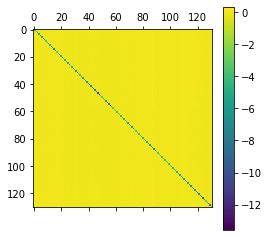

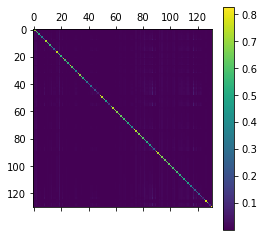

In [72]:
elasticities_blp= blp_results_gh.compute_elasticities()
diversions_blp = blp_results_gh.compute_diversion_ratios()
plt.colorbar(plt.matshow(elasticities_blp));
plt.colorbar(plt.matshow(diversions_blp));

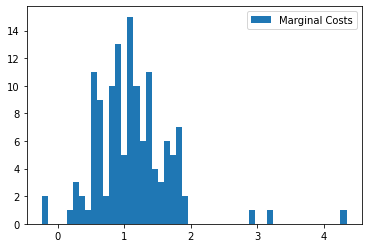

In [73]:
costs_blp = blp_results.compute_costs()
plt.hist(costs_blp, bins=50);
plt.legend(["Marginal Costs"]);

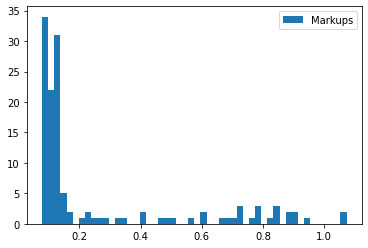

In [74]:
markups_blp = blp_results.compute_markups(costs=costs_blp)
plt.hist(markups_blp, bins=50);
plt.legend(["Markups"]);

### Question 8: Incorporate micro moments

- The micro moment will come into the equation in the following way: ($x_{j}=hp_{j}/weight_{j}$)
$
Corr\left( y_{i},x_{j}\right) =\frac{E\left[ \left( y_{i}-E(y)\right) \left(
x_{j}-E(x)\right) \right] }{\sigma _{y}\sigma _{x}}=0.7
$

- The denominator is directly from the data, the nemurator, denote $C_{i}=j~$
as $i~$buys car $j$ 
$
\begin{split}
E\left[ (y_{i}-\mu _{y})\left( x_{j}-\mu _{x}\right) |\beta ,\alpha \right] 
&=&\sum_{j}s_{j}\left( x_{j}-\mu _{x}\right) \times E\left[ (y_{i}-\mu
_{y})|C_{i}=j;\beta ,\alpha \right]  \\
&=&\sum_{j}s_{j}\left( x_{j}-\mu _{x}\right) \times \int_{y_{i}}(y_{i}-\mu
_{y})\Pr \left( y_{i}|C_{i}=j;\beta ,\alpha \right)  \\
\text{(from Beyes' rule)} &=&\sum_{j}s_{j}\left( x_{j}-\mu _{x}\right)
\times \frac{\int_{y_{i}}(y_{i}-\mu _{y})\Pr \left( C_{i}=j|y_{i};\beta
,\alpha \right) dF(y_{i})}{\Pr \left( C_{i}=j,\beta ,\alpha \right) } \\
\text{(by simulation)} &=&\sum_{j}s_{j}\left( x_{j}-\mu _{x}\right) \times 
\frac{\left( N\right) ^{-1}\sum_{r}(y_{r}-\mu _{y})\Pr \left(
C_{i}=j|y_{r};\beta ,\alpha \right) }{s_{j}^{N}} \\
&=&\sum_{j}s_{j}\left( x_{j}-\mu _{x}\right) \times \frac{\left( N\right)
^{-1}}{s_{j}^{N}}\sum_{r}(y_{r}-\mu _{y})\frac{\exp (\hat{\delta}_{j}\left(
\alpha \right) -\frac{p_{j}}{y_{r}})}{1+\sum_{k}\exp (\hat{\delta}_{k}\left(
\alpha \right) -\frac{p_{k}}{y_{r}})}
\end{split}
$

- The moment would be:
$
\begin{split}
&&E[\frac{1}{N}\sum_{j}\left( x_{j}-\mu _{x}\right) \times
\sum_{r}(y_{r}-\mu _{y})\frac{\exp (\hat{\delta}_{j}\left( \alpha \right) -%
\frac{p_{j}}{y_{r}})}{1+\sum_{k}\exp (\hat{\delta}_{k}\left( \alpha \right) -%
\frac{p_{k}}{y_{r}})}-0.7\sigma _{y}\sigma _{x}]=0 \\
&&\sigma _{y}=45000\text{ (known), }\sigma _{x}=\sqrt{\sum_{j}\frac{n_{j}}{N}%
\left( x_{j}-\mu _{x}\right) ^{2}}=\sqrt{\sum_{j}s_{j}\left( x_{j}-\mu
_{x}\right) ^{2}}
\end{split}
$

In [29]:
# Data standard errors of power.
np.sqrt(np.cov(dataset['power'], aweights=dataset['quantity']))

0.34169321984487205

In [87]:
moment_power_income= pyblp.DemographicInteractionMoment(1, 1, 0.7*45*
                                                        np.sqrt(np.cov(dataset['power'], aweights=dataset['quantity'])), 1000)

In [89]:
initial_sigma = np.diag([0,0])
initial_pi = np.diag([-100, 0])
initial_beta = logit_demandonly.to_dict(['beta'])['beta']
blp_micro_results = problem_gh.solve(
    initial_sigma,
    initial_pi,
    micro_moments= [moment_power_income],
    initial_update= True
)
blp_micro_results

Problem Results Summary:
GMM   Objective  Gradient            Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Hessian   Shares   Condition Number  Condition Number 
----  ---------  --------  --------  -------  ----------------  -----------------
 2    +3.2E+01   +6.8E-10  +1.3E+01     0         +1.0E+19          +1.6E+03     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:01:03       Yes          13           52          32186        96630   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:   prices    power    |   Pi:    1*1/income   income 
------  --------  --------  |  ------  ----------  --------
prices  +0.0E+00            |  prices   +1.6E+01   +0.0E+00
                            |          (+4.2E-01)          
                 